# The Uninsured in America

## Introduction

Aren Carpenter - DS Cohort 062220

I will be creating a linear regression model as an explanatory tool to explore the factors that impact the rate of uninsured in the United States. People without health insurance can receive a lower standard of care due to their inability to pay for necessary operations or even routine checkups. Previous research has identified rural counties as harder hit by this phenomenon. 

My model will utilize community health indicators from the CDC and demographic/financial data from the Census Bureau for each county in the United States. With this data, I hope to provide comment on how to lower the rate of uninsured.

### Libraries to Import

In [209]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats as sms
import scipy.stats

from sklearn.dummy import DummyRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV

import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_columns', 50)
%matplotlib inline

### Load In Four Datasets

In [210]:
df = pd.read_csv('/Users/arencarpenter/Desktop/chsi_dataset/RISKFACTORSANDACCESSTOCARE.csv', na_values=['-1111.1', '-2222', '-2222.2'])
df_rural_urban = pd.read_csv('/Users/arencarpenter/Desktop/PctUrbanRural_County.csv')
df_income = pd.read_csv('/Users/arencarpenter/Desktop/2015 Median Income by County.csv')
df_demo = pd.read_csv('/Users/arencarpenter/Desktop/demographics.csv')

In [211]:
df_income = df_income.iloc[:3141] # Select only the 3,141 counties in the US, not territories.
df_income

,State,County,Median household income
0,Alabama,Autauga County,51281.0
1,Alabama,Baldwin County,50254.0
2,Alabama,Barbour County,32964.0
3,Alabama,Bibb County,38678.0
4,Alabama,Blount County,45813.0
...,...,...,...
3136,Wyoming,Sublette County,81772.0
3137,Wyoming,Sweetwater County,69022.0
3138,Wyoming,Teton County,75325.0
3139,Wyoming,Uinta County,56569.0


## Processing

Primary Care Physician Rate and Dentist Rate are reported per 100k population.

In [212]:
df.Community_Health_Center_Ind = df.Community_Health_Center_Ind - 1  # These were reported as 1 and 2, not 0 and 1. 
df.HPSA_Ind = df.HPSA_Ind - 1

In [213]:
df = pd.concat([df, df_rural_urban, df_income, df_demo], axis=1) # Concatenate our datasets.

The community health indicators dataset included confidence intervals as separate columns for each of the values. So dropped those as they don't provide additional information.

In [215]:
df.drop(columns=['CI_Min_No_Exercise', 'CI_Max_No_Exercise', 'CI_Min_Fruit_Veg', 'CI_Max_Fruit_Veg', 'CI_Min_Obesity', 
               'CI_Max_Obesity', 'CI_Min_High_Blood_Pres', 'CI_Max_High_Blood_Pres', 'CI_Min_Smoker', 'CI_Max_Smoker',
               'CI_Min_Diabetes', 'CI_Max_Diabetes', 'STATE', 'COUNTY', 'STATENAME', 'COUNTYNAME', 'POPDEN_URBAN',
               'POPDEN_RURAL', 'County_FIPS_Code', 'State', 'County', 'county', 'state', 'pctprivatecoveragealone'], 
        inplace=True)

In [216]:
df = df[df.State_FIPS_Code.notnull()] # Remove US territories from the list.

In [217]:
df.shape # We now have only the 3141 US counties.

(3141, 49)

In [218]:
df.head(15) # Let's look at all of our columns

,State_FIPS_Code,CHSI_County_Name,CHSI_State_Name,CHSI_State_Abbr,Strata_ID_Number,No_Exercise,Few_Fruit_Veg,Obesity,High_Blood_Pres,Smoker,Diabetes,Uninsured,Elderly_Medicare,Disabled_Medicare,Prim_Care_Phys_Rate,Dentist_Rate,Community_Health_Center_Ind,HPSA_Ind,POP_COU,POP_URBAN,POPPCT_URBAN,AREA_URBAN,AREAPCT_URBAN,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,Median household income,medincome,povertypercent,medianagemale,medianagefemale,percentmarried,no_hs_24,hs_24,college_24,hs_25,college_25,pctemployed,pctunemployed,pctprivatecoverage,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds
0,1.0,Autauga,Alabama,AL,29.0,27.8,78.6,24.5,29.1,26.6,14.2,5690.0,4762.0,1209.0,45.3,22.6,0.0,1.0,54571,31650,58.00,50882539,3.30,22921,42.00,1.488700e+09,96.70,51281.0,54366.0,13.1,36.7,38.4,54.8,19.1,38.8,5.4,33.5,13.5,NaN,7.6,73.1,46.1,30.0,14.3,77.399902,18.679488,0.967023,0.925373,56.069818
1,1.0,Baldwin,Alabama,AL,16.0,27.2,76.2,23.6,30.5,24.6,7.2,19798.0,22635.0,3839.0,67.0,30.8,0.0,1.0,182265,105205,57.72,275001368,6.68,77060,42.28,3.842520e+09,93.32,50254.0,49626.0,13.0,40.9,43.3,53.8,17.7,33.4,8.6,28.8,19.3,55.0,7.5,67.6,42.6,33.7,17.5,86.431496,9.601734,0.669841,0.958380,53.935010
2,1.0,Barbour,Alabama,AL,51.0,NaN,NaN,25.6,NaN,17.7,6.6,5126.0,3288.0,1092.0,45.8,24.6,0.0,1.0,27457,8844,32.21,17447656,0.76,18613,67.79,2.274371e+09,99.24,32964.0,34971.0,25.4,36.6,41.9,41.5,25.1,43.4,1.8,34.5,7.5,39.5,17.6,52.7,30.3,46.6,26.5,47.363731,46.765929,0.905985,3.445715,43.276946
3,1.0,Bibb,Alabama,AL,42.0,NaN,86.6,NaN,NaN,NaN,13.1,3315.0,2390.0,974.0,41.8,18.6,0.0,0.0,22915,7252,31.65,18903236,1.17,15663,68.35,1.593578e+09,98.83,38678.0,39546.0,18.1,37.8,40.4,49.0,25.3,33.1,1.2,42.1,6.1,45.2,8.3,64.8,43.8,39.4,22.7,76.654574,21.438683,0.092904,0.030968,57.335990
4,1.0,Blount,Alabama,AL,28.0,33.5,74.6,24.2,NaN,23.6,8.4,8131.0,5019.0,1300.0,16.2,10.8,1.0,0.0,57322,5760,10.05,10874700,0.65,51562,89.95,1.659087e+09,99.35,45813.0,45567.0,17.5,39.6,41.9,59.0,19.4,33.3,3.0,33.4,8.6,48.4,7.7,66.2,44.7,35.9,19.0,95.097903,1.531797,0.143823,0.961705,59.439854
5,1.0,Bullock,Alabama,AL,75.0,NaN,NaN,NaN,NaN,NaN,NaN,2295.0,1433.0,504.0,54.3,18.1,0.0,0.0,10914,5307,48.63,12675709,0.79,5607,51.37,1.600381e+09,99.21,31938.0,26580.0,35.1,37.9,40.6,28.9,8.2,65.5,0.0,33.3,6.5,44.7,18.0,48.1,32.4,44.3,28.9,26.643566,70.706125,0.206031,0.000000,31.794733
6,1.0,Butler,Alabama,AL,76.0,24.5,NaN,22.0,NaN,27.3,9.5,4055.0,3150.0,952.0,43.3,19.3,0.0,1.0,20947,6026,28.77,10503875,0.52,14921,71.23,2.001473e+09,99.48,32229.0,41123.0,20.5,37.5,40.6,48.2,13.9,28.3,4.8,31.8,10.7,50.8,12.3,65.0,39.3,39.7,20.2,75.110589,20.484706,0.857280,0.996159,47.191832
7,1.0,Calhoun,Alabama,AL,6.0,29.2,81.9,27.0,33.2,25.5,11.2,16456.0,16440.0,5301.0,75.8,41.9,0.0,1.0,118572,78617,66.30,210145581,13.39,39955,33.70,1.359044e+09,86.61,41703.0,34116.0,21.3,41.5,43.9,43.9,14.2,42.6,3.9,38.4,7.6,49.8,8.9,57.7,38.6,42.2,24.1,57.666011,40.312216,0.762933,0.035212,40.552695
8,1.0,Chambers,Alabama,AL,50.0,34.7,84.6,NaN,NaN,11.7,17.1,5533.0,5473.0,1497.0,53.6,22.6,0.0,1.0,34215,17399,50.85,54790707,3.55,16816,49.15,1.490219e+09,96.45,34177.0,38013.0,18.6,44.6,46.2,62.1,15.8,38.3,5.5,36.4,7.9,47.8,7.9,66.3,39.9,43.3,20.3,92.921409,4.925408,0.338357,0.065365,57.173258
9,1.0,Cherokee,Alabama,AL,64.0,NaN,NaN,NaN,NaN,23.6,13.3,3583.0,3086.0,854.0,28.5,12.2,1.0,0.0,25989,3707,14.26,26419773,1.84,22282,85.74,1.407656e+09,98.16,36296.0,41450.0,18.1,37.6,39.6,54.4,13.5,41.9,3.6,39.2,9.1,52.1,9.1,60.8,41.3,35.1,20.4,84.045734,10.333417,0.287546,4.119218,54.862351


### Imputing Missing Community Indicators

Using the state average for each missing community health indicator. I looked at histograms for the CHSI values and they were normally distributed, so I used the mean to impute.

In [220]:
def impute_state_avg(column, state):
    state_avg = df[df.CHSI_State_Name == state][column].mean()
    print(state + " State Avg for " + column + ": " + str(state_avg))

    df[column] = df[column].fillna(state_avg)

In [221]:
states = df.CHSI_State_Name.unique()
columns = ['No_Exercise','Few_Fruit_Veg', 'Obesity', 'High_Blood_Pres', 'Smoker', 'Diabetes', 'Elderly_Medicare', 
           'Disabled_Medicare', 'Dentist_Rate']

In [222]:
def impute():
    for column in columns:
        for state in states:
            impute_state_avg(column, state)

In [223]:
impute()

Alabama State Avg for No_Exercise: 29.794999999999995
Alaska State Avg for No_Exercise: 29.794999999999987
Arizona State Avg for No_Exercise: 25.652999999999995
Arkansas State Avg for No_Exercise: 31.0486
California State Avg for No_Exercise: 24.272413793103446
Colorado State Avg for No_Exercise: 24.02242187500001
Connecticut State Avg for No_Exercise: 20.9375
Delaware State Avg for No_Exercise: 25.933333333333334
District of Columbia State Avg for No_Exercise: 22.2
Florida State Avg for No_Exercise: 27.122835820895528
Georgia State Avg for No_Exercise: 28.849905660377388
Hawaii State Avg for No_Exercise: 21.238999999999997
Idaho State Avg for No_Exercise: 22.9475
Illinois State Avg for No_Exercise: 27.300196078431398
Indiana State Avg for No_Exercise: 27.686304347826102
Iowa State Avg for No_Exercise: 25.966868686868693
Kansas State Avg for No_Exercise: 28.326809523809548
Kentucky State Avg for No_Exercise: 34.45500000000002
Louisiana State Avg for No_Exercise: 34.683671875000016
Main

Hawaii State Avg for High_Blood_Pres: 25.4
Idaho State Avg for High_Blood_Pres: 26.859090909090913
Illinois State Avg for High_Blood_Pres: 29.245098039215645
Indiana State Avg for High_Blood_Pres: 28.508695652173895
Iowa State Avg for High_Blood_Pres: 26.391919191919175
Kansas State Avg for High_Blood_Pres: 29.44571428571425
Kentucky State Avg for High_Blood_Pres: 31.00333333333331
Louisiana State Avg for High_Blood_Pres: 30.367187499999986
Maine State Avg for High_Blood_Pres: 24.79375
Maryland State Avg for High_Blood_Pres: 27.82083333333333
Massachusetts State Avg for High_Blood_Pres: 25.664285714285715
Michigan State Avg for High_Blood_Pres: 29.1180722891566
Minnesota State Avg for High_Blood_Pres: 28.118390804597674
Mississippi State Avg for High_Blood_Pres: 31.667073170731687
Missouri State Avg for High_Blood_Pres: 30.210434782608655
Montana State Avg for High_Blood_Pres: 27.703571428571415
Nebraska State Avg for High_Blood_Pres: 28.318279569892443
Nevada State Avg for High_Blood_

Nevada State Avg for Elderly_Medicare: 13906.058823529413
New Hampshire State Avg for Elderly_Medicare: 15196.7
New Jersey State Avg for Elderly_Medicare: 51087.09523809524
New Mexico State Avg for Elderly_Medicare: 6393.272727272727
New York State Avg for Elderly_Medicare: 38072.91935483871
North Carolina State Avg for Elderly_Medicare: 9802.08
North Dakota State Avg for Elderly_Medicare: 2206.3728527175444
Ohio State Avg for Elderly_Medicare: 16886.840909090908
Oklahoma State Avg for Elderly_Medicare: 5742.194805194805
Oregon State Avg for Elderly_Medicare: 12372.5
Pennsylvania State Avg for Elderly_Medicare: 27541.955223880595
Rhode Island State Avg for Elderly_Medicare: 29135.4
South Carolina State Avg for Elderly_Medicare: 10557.804347826086
South Dakota State Avg for Elderly_Medicare: 1627.409090909091
Tennessee State Avg for Elderly_Medicare: 7395.5368421052635
Texas State Avg for Elderly_Medicare: 8378.259960042305
Utah State Avg for Elderly_Medicare: 6942.1811631497685
Vermont

### Dropping Missing Values from Target Variable

In [224]:
df[df.Uninsured.isnull()]

,State_FIPS_Code,CHSI_County_Name,CHSI_State_Name,CHSI_State_Abbr,Strata_ID_Number,No_Exercise,Few_Fruit_Veg,Obesity,High_Blood_Pres,Smoker,Diabetes,Uninsured,Elderly_Medicare,Disabled_Medicare,Prim_Care_Phys_Rate,Dentist_Rate,Community_Health_Center_Ind,HPSA_Ind,POP_COU,POP_URBAN,POPPCT_URBAN,AREA_URBAN,AREAPCT_URBAN,POP_RURAL,POPPCT_RURAL,AREA_RURAL,AREAPCT_RURAL,Median household income,medincome,povertypercent,medianagemale,medianagefemale,percentmarried,no_hs_24,hs_24,college_24,hs_25,college_25,pctemployed,pctunemployed,pctprivatecoverage,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds
249,8.0,Broomfield,Colorado,CO,27.0,14.400,80.08,21.500000,15.9,17.400000,3.300000,NaN,8486.253731,2246.58209,87.4,23.977612,1.0,1.0,6499,4032,62.04,3651419,0.09,2467,37.96,3.914641e+09,99.91,36791.0,83603.0,5.9,45.1,45.2,62.6,18.2,32.9,11.0,27.0,22.0,64.7,6.7,77.9,51.7,22.9,10.8,95.275624,0.528191,0.838399,0.301824,68.195319
317,11.0,Washington,District of Columbia,DC,3.0,22.200,68.10,21.300000,26.7,20.400000,7.800000,NaN,63403.000000,10262.00000,227.6,102.800000,0.0,1.0,538479,513696,95.40,543209334,49.20,24783,4.60,5.608655e+08,50.80,65476.0,36788.0,25.3,39.1,48.7,49.8,37.6,20.3,1.4,35.4,10.1,43.9,9.4,52.8,28.7,43.3,20.9,81.991744,14.551084,0.756794,0.455796,50.507146
546,15.0,Kalawao,Hawaii,HI,37.0,29.795,80.08,26.897561,31.6,23.822917,9.651563,NaN,8486.253731,2246.58209,0.0,0.000000,1.0,1.0,185079,114766,62.01,224652200,2.15,70313,37.99,1.020890e+10,97.85,52108.0,44669.0,17.1,35.3,37.2,59.1,23.0,44.2,4.3,33.1,8.9,59.9,3.8,50.5,27.3,37.6,22.4,86.437340,0.072212,0.597387,9.440032,59.883612


In [225]:
df.shape

(3141, 49)

In [226]:
df = df.dropna() # There was a subset of counties in remote areas that had very little data collected from them

In [227]:
df.shape

(2891, 49)

## Removing Correlated Features

In [228]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)
# Drop features 
df.drop(to_drop, axis=1, inplace=True)

['Disabled_Medicare', 'POP_URBAN', 'POPPCT_RURAL', 'AREAPCT_RURAL']


## Feature Engineering

I had total number of uninsured, but in order to keep population from overwhelming the differences between counties, I converted to a percentage.

In [229]:
df['Percent_Uninsured'] = round(df.Uninsured / df.POP_COU * 100, 3)

I hypothesized from the community health indicators that the presence of community health centers would affect counties differently depending on if they were rural or urban. Because there are fewer facilities in rural areas, I predicted that a community health center would have a greater affect.

In [230]:
df['CHC_x_POPPCT_URBAN'] = df.Community_Health_Center_Ind * df.POPPCT_URBAN

In [231]:
df['HPSA_x_POPPCT_URBAN'] = df.HPSA_Ind * df.POPPCT_URBAN

In [232]:
df['Median_Household_Income'] = df['Median household income'] # Renaming to remove spaces

Because of some differences in the datasets, some counties had greater than 100% uninsured rates, which are obvious outliers. 

In [234]:
df = df[df.Percent_Uninsured <= 100] # Remove percents greater than 100%

In [235]:
df.shape

(2599, 49)

## EDA & Visualizations

Let's start by looking at the distribution of counties by the uninsured rate.

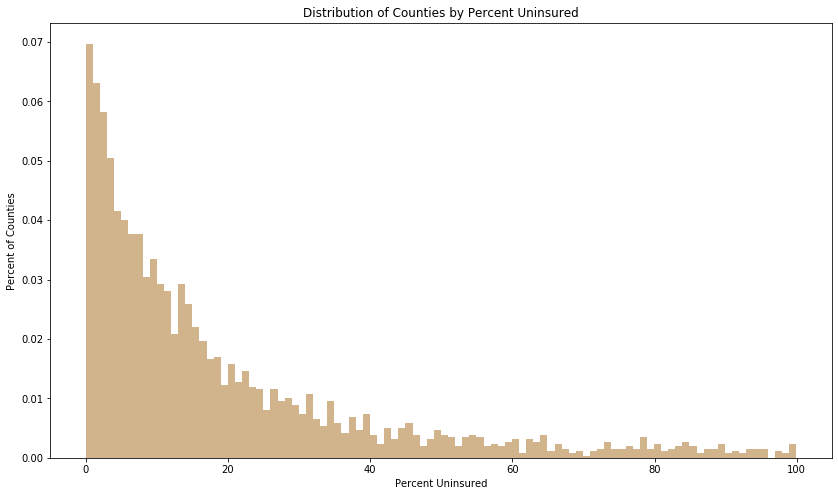

In [236]:
plt.figure(figsize=(14,8))
plt.hist(df.Percent_Uninsured, bins=100, density=True, color='tan')
plt.title('Distribution of Counties by Percent Uninsured')
plt.xlabel('Percent Uninsured')
plt.ylabel('Percent of Counties')
plt.show()

We can see that most counties have less than 10% uninsured, but there is a wide range of percentages. The highest values are in counties with small, sparse populations.

### Stat Test: Two Proportion Z-Test 
#### Do rural and urban counties have different incidence of Community Health Centers?

From research, using a 75% cutoff to define county. I.e. counties with greater than 75% of their population urban, are urban, otherwise they are rural.

In [237]:
df_rural = df[df.POPPCT_URBAN <= 75]
df_urban = df[df.POPPCT_URBAN > 75]

In [238]:
len(df_rural)

2091

In [239]:
len(df_urban)

508

Define presence of Community Health Center.

In [240]:
df_rural_CHC = df_rural[df_rural.Community_Health_Center_Ind == 1.0]

In [241]:
len(df_rural_CHC)

1240

In [242]:
df_urban_CHC = df_urban[df_urban.Community_Health_Center_Ind == 1.0]

In [243]:
len(df_urban_CHC)

253

In [244]:
sms.proportion.proportions_ztest([len(df_rural_CHC), len(df_urban_CHC)], [len(df_rural), len(df_urban)])

(3.8838732946017176, 0.00010280549625075338)

P-value = 0.0001, so can reject null hypothesis and conclude that there is a difference between rural and urban counties regarding the presence of community health centers.

### Stat Test 2: Two Proportion Z-Test 
#### Do rural and urban counties have a different rate of underservedness?

Define if the county is medically underserved.

In [248]:
df_rural_HPSA = df_rural[df_rural.HPSA_Ind == 1.0]

In [249]:
len(df_rural_HPSA)

1519

In [250]:
df_urban_HPSA = df_urban[df_urban.HPSA_Ind == 1.0]

In [251]:
len(df_urban_HPSA)

394

In [252]:
sms.proportion.proportions_ztest([len(df_rural_HPSA), len(df_urban_HPSA)], [len(df_rural), len(df_urban)])

(-2.254041286737303, 0.024193570745392797)

P-value = 0.024, so can reject null hypothesis and conclude that there is a difference between rural and urban counties regarding their underservedness.

Looking at the visualization...

In [253]:
x = ['Urban', 'Rural']
y = [df_urban.HPSA_Ind.mean(), df_rural.HPSA_Ind.mean()]

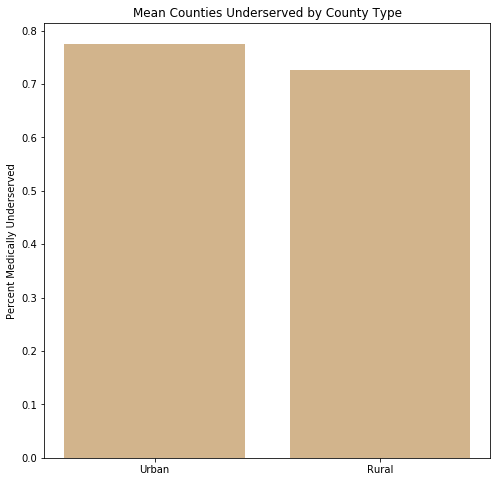

In [254]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='tan')
plt.title('Mean Counties Underserved by County Type')
plt.ylabel('Percent Medically Underserved')
plt.show()

Note that the percentage of underserved counties is high regardless of urban/rural.

### Stat Test 3: Two Means T-Test 
#### Do rural and urban counties have a different rate of uninsured?

In [256]:
rural = df_rural.Percent_Uninsured

In [257]:
urban = df_urban.Percent_Uninsured

In [258]:
scipy.stats.ttest_ind(rural, urban)

Ttest_indResult(statistic=11.917737293476847, pvalue=6.399598718670862e-32)

There is a statistical difference between the uninsured rate between rural and urban counties, and that difference is large (21% vs 9% uninsured). 

In [259]:
rural.mean()

21.163396461023442

In [260]:
urban.mean()

9.157561023622048

P-value = 6.39 x 10<sup>-32</sup>, so we can reject the null hypothesis and conclude that there is a significant difference between rural and urban counties and their respective rates of uninsured.

Looking at the visualization...

In [261]:
x = ['Urban', 'Rural']
y = [urban.mean(), rural.mean()]

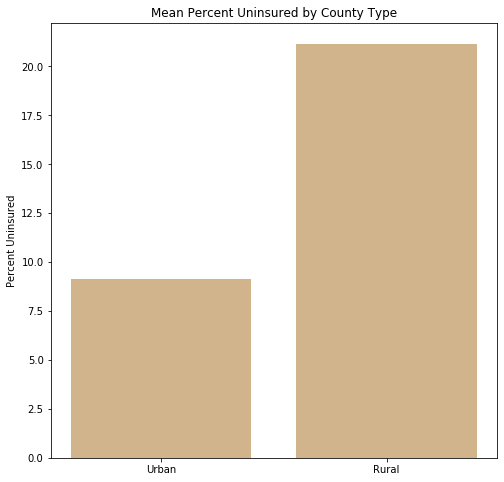

In [262]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='tan')
plt.title('Mean Percent Uninsured by County Type')
plt.ylabel('Percent Uninsured')
plt.show()

### Stat Test 4: Two Means T-Test 
#### Do rural and urban counties have different median household incomes?

Define median household income.

In [264]:
rural = df_rural.Median_Household_Income

In [265]:
urban = df_urban.Median_Household_Income

In [266]:
scipy.stats.ttest_ind(rural, urban)

Ttest_indResult(statistic=-19.708604869463954, pvalue=1.0763289819633104e-80)

There is more than a \$10,000 difference between the median household income for urban and rural counties.

In [267]:
rural.mean()

44728.4074605452

In [268]:
urban.mean()

56133.580708661415

P-value = 1.07 x 10<sup>-80</sup>, so we can reject the null hypothesis and conclude that there is a significant difference between rural and urban counties and their median household income.

Looking at the visualization...

In [269]:
x = ['Urban', 'Rural']
y = [df_urban.Median_Household_Income.mean(), df_rural.Median_Household_Income.mean()]

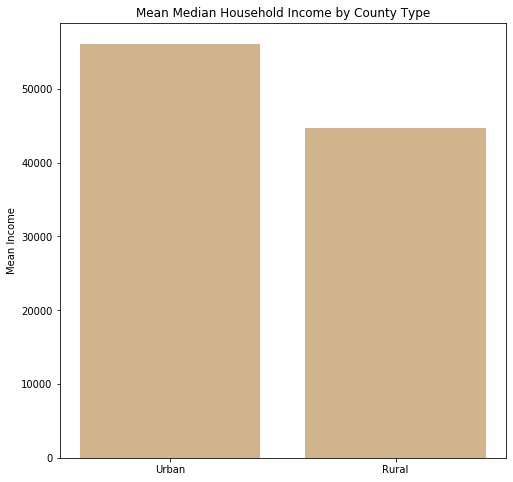

In [270]:
plt.figure(figsize=(8,8))
plt.bar(x, y, color ='tan')
plt.title('Mean Median Household Income by County Type')
plt.ylabel('Mean Income')

plt.show()

## Starting to Model

Let's define our target variable and then drop it from the dataframe.

In [160]:
target = df.Percent_Uninsured

In [161]:
df = df.drop(columns=['Uninsured', 'Percent_Uninsured']) # Remove our target variables.

I'm splitting our continuous and categorical variables so that I can scale just the continuous ones later.

In [162]:
continuous_variables = ['No_Exercise', 'Few_Fruit_Veg', 'Obesity', 'High_Blood_Pres', 'Smoker', 'Diabetes', 
                        'Elderly_Medicare', 'Prim_Care_Phys_Rate', 'Dentist_Rate', 'POP_COU', 'POPPCT_URBAN',
                        'AREA_URBAN', 'AREAPCT_URBAN', 'POP_RURAL', 'AREA_RURAL', 'CHC_x_POPPCT_URBAN', 
                        'HPSA_x_POPPCT_URBAN', 'Median_Household_Income', 'povertypercent', 'medianagemale', 
                        'percentmarried', 'no_hs_24', 'hs_24', 'college_24', 'hs_25', 'college_25', 'pctemployed',
                        'pctunemployed', 'pctprivatecoverage', 'pctempprivcoverage', 'pctpubliccoverage', 
                        'pctpubliccoveragealone', 'pctwhite', 'pctblack', 'pctasian', 'pctotherrace', 
                        'pctmarriedhouseholds']
categorical_variables = ['Community_Health_Center_Ind', 'HPSA_Ind']

df_cont = df[continuous_variables]
df_cate = df[categorical_variables]

In [163]:
df_features = pd.concat([df_cont, df_cate], axis=1)

### Train Test Split

In [164]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9)

In [165]:
print("X_train Shape: " + str(X_train.shape))
print("X_test Shape:  " + str(X_test.shape))
print("y_train Shape: " + str(y_train.shape))
print("y_test Shape:  " + str(y_test.shape))

X_train Shape: (1949, 39)
X_test Shape:  (650, 39)
y_train Shape: (1949,)
y_test Shape:  (650,)


### Dummy Baseline

This dummy baseline model will predict the mean uninsured rate for every county. Our model should be able to beat it if our features are able to explain more of the variance in the data than just the mean.

In [166]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

dummy_regr.predict(X_train)

dummy_regr.score(X_train, y_train)

0.0

### Baseline Model - No Transformations

In [167]:
# Instantiate a linear regression object.
model = linear_model.LinearRegression()

# Fit the linear regression to the data.
model = model.fit(X_train, y_train)

# Predict on our X_train data.
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Training RMSE:' , train_rmse)
print ("R^2 Score:", model.score(X_train, y_train))

Training RMSE: 16.370039894265265
R^2 Score: 0.3905351160066315


Here are all of our untransformed features and their coefficients. Let's try scaling our continuous variables next.

In [168]:
tuple(zip(df_features.columns, model.coef_))

(('No_Exercise', -0.13922376961822422),
 ('Few_Fruit_Veg', -0.076092135540925),
 ('Obesity', 0.131642080989579),
 ('High_Blood_Pres', -0.5850351799610971),
 ('Smoker', 0.33193040082524067),
 ('Diabetes', -0.03350060633771633),
 ('Elderly_Medicare', 0.0003948935954233043),
 ('Prim_Care_Phys_Rate', 0.04468326811322583),
 ('Dentist_Rate', 0.022233972399334872),
 ('POP_COU', -5.3053247644044314e-06),
 ('POPPCT_URBAN', -0.24398507230861707),
 ('AREA_URBAN', 6.797564414625148e-09),
 ('AREAPCT_URBAN', -0.10382043742758777),
 ('POP_RURAL', -0.00039243260384667493),
 ('AREA_RURAL', -6.578437606258139e-11),
 ('CHC_x_POPPCT_URBAN', 0.09220449128403178),
 ('HPSA_x_POPPCT_URBAN', -0.04489130473130484),
 ('Median_Household_Income', -0.00015515371827052652),
 ('povertypercent', 0.145567272271349),
 ('medianagemale', 0.17472617378764055),
 ('percentmarried', -0.07020806493189967),
 ('no_hs_24', 0.006626052762510628),
 ('hs_24', 0.025818927749259465),
 ('college_24', -0.13160217602793947),
 ('hs_25', 0

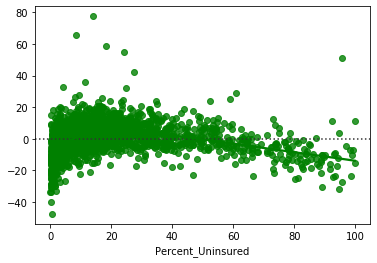

In [169]:
sns.residplot(y_train, y_train_pred,lowess=True, color="g")

### Model - Scaling Continuous Variables

In [171]:
#Scaling our continuous variables:
scaler = StandardScaler()
scaled_df_cont = pd.DataFrame(scaler.fit_transform(df_cont), columns = continuous_variables)
scaled_df_cont.head()

,No_Exercise,Few_Fruit_Veg,Obesity,High_Blood_Pres,Smoker,Diabetes,Elderly_Medicare,Prim_Care_Phys_Rate,Dentist_Rate,POP_COU,POPPCT_URBAN,AREA_URBAN,AREAPCT_URBAN,POP_RURAL,AREA_RURAL,CHC_x_POPPCT_URBAN,HPSA_x_POPPCT_URBAN,Median_Household_Income,povertypercent,medianagemale,percentmarried,no_hs_24,hs_24,college_24,hs_25,college_25,pctemployed,pctunemployed,pctprivatecoverage,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds
0,-0.140728,-0.833895,-0.365908,0.217572,0.218053,-0.378667,0.919808,0.288223,0.010932,0.213431,0.457721,0.760082,-0.065738,3.362688,0.179537,-0.751603,0.744785,0.262894,-0.609027,0.244370,0.295230,-0.059028,-0.173819,0.537401,-0.875305,1.135858,0.096162,-0.104687,0.298370,0.143838,-0.337689,-0.285384,0.165771,0.026891,-0.217984,-0.281841,0.425974
1,0.319560,0.132581,0.099834,0.471333,-1.200359,-0.602950,-0.264460,-0.188297,-0.274300,-0.243278,-0.356155,-0.346360,-0.395972,-0.084651,-0.049164,-0.751603,-0.023094,-1.116039,1.316746,-0.588177,-1.499886,0.859029,0.922702,-0.973919,-0.062080,-1.078077,-1.780871,2.824671,-1.106610,-1.164279,1.313023,1.184001,-2.236444,2.570227,-0.125638,0.441741,-1.210808
2,0.319560,1.756660,0.401999,0.471333,0.058310,1.826783,-0.319429,-0.278206,-0.550331,-0.256678,-0.374022,-0.340107,-0.373101,-0.258649,-0.148453,-0.751603,-0.992650,-0.660329,0.183025,-0.355838,-0.405303,0.883842,-0.206715,-1.107271,1.022219,-1.340748,-1.090607,0.127341,0.034347,0.271459,0.391695,0.563594,-0.435396,0.836954,-0.443601,-0.551631,0.948270
3,0.976732,-1.232442,-0.226185,0.471333,0.012486,0.069899,-0.158502,-0.853626,-0.909172,-0.155171,-1.063152,-0.374597,-0.402108,1.858757,-0.138899,-0.425729,-0.992650,-0.091290,0.089842,-0.007330,1.054141,0.151877,-0.184784,-0.707216,-0.219018,-0.871694,-0.703091,-0.046680,0.166359,0.367175,-0.056172,-0.040486,0.698655,-0.525376,-0.423689,-0.280874,1.271365
4,0.319560,0.132581,0.401999,0.471333,0.058310,0.537740,-0.378008,0.002761,-0.573334,-0.292083,0.167712,-0.366860,-0.394298,-0.851775,-0.147460,-0.751603,-0.992650,-1.197866,2.823197,-0.336477,-3.338785,-1.237616,3.346013,-1.373975,-0.233285,-1.265699,-1.151157,2.940685,-1.540362,-0.940942,1.018710,1.575836,-3.510495,4.208577,-0.399361,-0.560640,-2.974156


In [172]:
df_total = pd.concat([scaled_df_cont, df_cate], axis=1)

In [173]:
df_total = df_total.fillna(0.0)
df_total = df_total.iloc[:2599]

### Train Test Split

In [174]:
X_train, X_test, y_train, y_test = train_test_split(df_total, target, random_state=7)

In [175]:
print("X_train Shape: " + str(X_train.shape))
print("X_test Shape:  " + str(X_test.shape))
print("y_train Shape: " + str(y_train.shape))
print("y_test Shape:  " + str(y_test.shape))

X_train Shape: (1949, 39)
X_test Shape:  (650, 39)
y_train Shape: (1949,)
y_test Shape:  (650,)


In [176]:
#instantiate a linear regression object
model2 = linear_model.LinearRegression()

#fit the linear regression to the data
model2 = model2.fit(X_train, y_train)

y_train_pred = model2.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training RMSE:' , train_rmse)
print ("R^2 Score:", model2.score(X_train, y_train))

Training RMSE: 16.905852945940143
R^2 Score: 0.3739339389923164


This RMSE and R2 are very similiar to the previous un-transformed model, as expected.

Here are all the features and their coefficients. We will use recursive elimination to narrow this list down to significant ones.

In [177]:
tuple(zip(df_features.columns, model2.coef_))

(('No_Exercise', -0.47521182332947964),
 ('Few_Fruit_Veg', -0.3312324466136487),
 ('Obesity', 0.4713131345856334),
 ('High_Blood_Pres', -2.1965456647826525),
 ('Smoker', 1.975156695625071),
 ('Diabetes', -0.23127420895117765),
 ('Elderly_Medicare', 6.329581337510448),
 ('Prim_Care_Phys_Rate', 3.260209346439927),
 ('Dentist_Rate', 0.37245647247199315),
 ('POP_COU', -1.363385482887224),
 ('POPPCT_URBAN', -6.208141717803918),
 ('AREA_URBAN', 1.1059051672278069),
 ('AREAPCT_URBAN', -1.9218166211196706),
 ('POP_RURAL', -6.170160622686675),
 ('AREA_RURAL', -0.3712380227106195),
 ('CHC_x_POPPCT_URBAN', -2.013712734670523),
 ('HPSA_x_POPPCT_URBAN', 0.6528580021609944),
 ('Median_Household_Income', -2.5079746583928917),
 ('povertypercent', 0.48853944980204644),
 ('medianagemale', 0.41932441712461704),
 ('percentmarried', -1.2513412558958203),
 ('no_hs_24', 0.3640091696682233),
 ('hs_24', 0.6823184636044524),
 ('college_24', -0.29060754264582217),
 ('hs_25', -0.45722482594649294),
 ('college_25'

## Recursive Feature Elimination

In [178]:
ols = linear_model.LinearRegression()

In [179]:
# Instantiate a recursive eliminator object
selector = RFECV(estimator=ols, step=1, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)



RFECV(cv=None,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [180]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]


In [186]:
len(list(removed_rfe)) # We eliminated 30 features from our model

30

In [182]:
list(selected_rfe) # Here are the features we are keeping

['High_Blood_Pres',
 'Smoker',
 'Elderly_Medicare',
 'Prim_Care_Phys_Rate',
 'POPPCT_URBAN',
 'AREAPCT_URBAN',
 'POP_RURAL',
 'CHC_x_POPPCT_URBAN',
 'Median_Household_Income']

Our final model with only significant features according to recursive elimination.

In [183]:
#instantiate a linear regression object
lm_rfe = linear_model.LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))
print('Training Root Mean Squared Error:' , trainRFE_rmse)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))
print('Testing Root Mean Squared Error:' , testRFE_rmse)

print ("R^2 Score:", lm_rfe.score(X_train[selected_rfe], y_train))

Training Root Mean Squared Error: 17.01058900868868
Testing Root Mean Squared Error: 15.686747553971113
R^2 Score: 0.3661526325855897


## Examine Coefficients

In [184]:
pd.DataFrame(zip(X_train[selected_rfe], lm_rfe.coef_))

,0,1
0,High_Blood_Pres,-2.234794
1,Smoker,1.926092
2,Elderly_Medicare,6.547118
3,Prim_Care_Phys_Rate,3.578030
4,POPPCT_URBAN,-5.628755
5,AREAPCT_URBAN,-1.927773
6,POP_RURAL,-5.940180
7,CHC_x_POPPCT_URBAN,-2.061759
8,Median_Household_Income,-2.437864


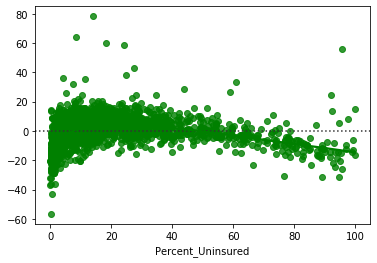

In [185]:
sns.residplot(y_train, y_rfe,lowess=True, color="g")

## Insights

So now we have a list of our significant features and their coefficients. We can see that the Elderly on Medicare, Smoker, and Primary Care Physician Rate all increase the uninsured rate as they increase. Conversely, High Blood Pressure, Urban Population and Area, and Median Household Income all decrease the uninsured rate as they increase. 